만약에, 우리가 Waveform 데이터 대신 이 Spectrogram 포맷으로 모든 음성 데이터를 변환한 후 음성인식 모델을 학습시킨다면, 과연 Waveform과 비교했을 때 더 나은 성능을 기대할 수 있을까요?

오늘 실습에서 1차원 Waveform 데이터를 입력받아 Text 라벨을 출력하는 모델을 기본 버전과 Skip-connection 버전으로 나누어 학습시켜 보았습니다. 이번에는 2차원 Spectrogram 데이터를 입력받아 위 모델과 동일한 역할을 수행하는 모델을 아래 제시된 단계와 같이 수행해 보시기 바랍니다. 이번에도 마찬가지로 기본 버전과 Skip-connection 버전으로 나누어 각각 진행해 보시기 바랍니다.
모델 구조를 제외하고는 실습에서 제시된 것과 거의 동일하게 진행될 것입니다.


In [1]:
import numpy as np
import os
import librosa
import IPython.display as ipd
import random
import matplotlib.pyplot as plt

In [2]:
data_path = os.getenv("HOME")+'/aiffel/speech_recognition/data/speech_wav_8000.npz'
speech_data = np.load(data_path)

# 데이터 선택 (랜덤하게 선택하고 있으니, 여러번 실행해 보세요)
rand = random.randint(0, len(speech_data["wav_vals"]))
print("rand num : ", rand)

sr = 8000 # 1초동안 재생되는 샘플의 갯수
data = speech_data["wav_vals"][rand]
print("Wave data shape : ", data.shape)
print("label : ", speech_data["label_vals"][rand])

ipd.Audio(data, rate=sr)

rand num :  5666
Wave data shape :  (8000,)
label :  ['left']


1. 데이터 처리와 분류
- **Label Data 처리**

In [3]:
target_list = ['yes', 'no', 'up', 'down', 'left', 'right', 'on', 'off', 'stop', 'go']

#target list에 unknow과 silence 추가
label_value = target_list
label_value.append('unknown')
label_value.append('silence')

print('LABEL : ', label_value)

new_label_value = dict()
for i, l in enumerate(label_value):
    new_label_value[l] = i
label_value = new_label_value

print('Indexed LABEL : ', new_label_value)

LABEL :  ['yes', 'no', 'up', 'down', 'left', 'right', 'on', 'off', 'stop', 'go', 'unknown', 'silence']
Indexed LABEL :  {'yes': 0, 'no': 1, 'up': 2, 'down': 3, 'left': 4, 'right': 5, 'on': 6, 'off': 7, 'stop': 8, 'go': 9, 'unknown': 10, 'silence': 11}


In [4]:
#Text로 이루어진 라벨데이터를 index 형태로 바꿈.
temp = []
for v in speech_data["label_vals"][:30000]:
    temp.append(label_value[v[0]])
label_data = np.array(temp)

label_data

array([3, 3, 3, ..., 7, 7, 7])

In [5]:
def wav2spec(wav, fft_size=258): # spectrogram shape을 맞추기위해서 size 변형
    # librosa.stft : Short time Fourier Transform
    D = np.abs(librosa.stft(wav, n_fft=fft_size))
    return D

# 위에서 뽑았던 sample data
spec = wav2spec(data)
print("Waveform shape : ",data.shape)
print("Spectrogram shape : ",spec.shape)

Waveform shape :  (8000,)
Spectrogram shape :  (130, 126)


- **데이터 분리**

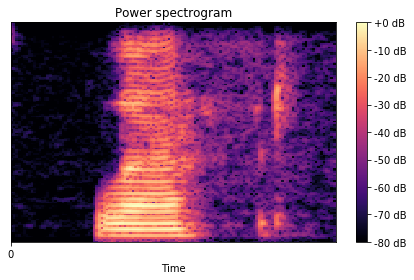

(130, 126)

In [6]:
import librosa.display

librosa.display.specshow(librosa.amplitude_to_db(spec, ref=np.max), x_axis='time')
plt.title('Power spectrogram')
plt.colorbar(format='%+2.0f dB')
plt.xticks(range(0, 1))
plt.tight_layout()
plt.show()
spec.shape

In [7]:
spec = []
spec_temp = []

for w in speech_data["wav_vals"][:30000]:
    spec_temp.append(wav2spec(w))
    
spec = np.array(spec_temp)
print(spec.shape)

(30000, 130, 126)


In [8]:
from sklearn.model_selection import train_test_split

train_wav, test_wav, train_label, test_label = train_test_split(spec, 
                                                                label_data, 
                                                                test_size=0.1,
                                                                shuffle=True)
print(train_wav)
print("train_wav shape : ", train_wav.shape)

'''
train_wav = train_wav.reshape([-1, 30000, 1]) # add channel for CNN
test_wav = test_wav.reshape([-1, 30000, 1])
'''

print("train data : ", train_wav.shape)
print("train labels : ", train_label.shape)
print("test data : ", test_wav.shape)
print("test labels : ", test_label.shape)
print("✅")

[[[2.31138051e-01 2.22608730e-01 1.26467764e-01 ... 2.82805214e+01
   1.11533813e+01 4.62558299e-01]
  [1.15991175e-01 1.47068888e-01 1.19933926e-01 ... 2.20141602e+01
   1.18433590e+01 3.04827952e+00]
  [1.53606683e-01 2.04002306e-01 3.33866149e-01 ... 8.67795277e+00
   8.66751575e+00 1.17593503e+00]
  ...
  [2.22640531e-03 1.68954534e-03 5.61785768e-04 ... 2.04562035e-04
   1.21652358e-03 2.28159479e-03]
  [2.79328204e-03 1.38312893e-03 1.00782760e-04 ... 1.34650283e-04
   6.35856530e-04 8.98688042e-04]
  [2.70096376e-03 1.33608666e-03 1.31146708e-05 ... 1.01993734e-04
   1.53959802e-04 5.03670366e-04]]

 [[9.97491777e-01 6.82201743e-01 2.49057904e-01 ... 8.02811146e-01
   5.00686049e-01 1.28787065e+00]
  [7.75137007e-01 3.96118969e-01 1.87891573e-01 ... 7.57486880e-01
   8.68590057e-01 1.01140618e+00]
  [3.11117351e-01 3.33005130e-01 2.05705360e-01 ... 6.41033798e-02
   4.95383412e-01 2.18939632e-01]
  ...
  [4.21241997e-03 2.04193033e-03 5.34380379e-04 ... 3.86267668e-04
   9.73809

2. 학습을 위한 하이퍼파라미터 설정

In [9]:
batch_size = 27
max_epochs = 10

# the save point
checkpoint_dir = os.getenv('HOME')+'/aiffel/speech_recognition/models/wav'

checkpoint_dir

'/home/ssac12/aiffel/speech_recognition/models/wav'

3. 데이터셋 구성
- `tf.data.Dataset` 이용
- from_tensor_slices 함수에 return 받길 원하는 데이터를 튜플 (data, label) 형태로 넣어서 사용
- map과 batch를 이용한 데이터 전처리
- 주의 : waveform을 spectrogram으로 변환하기 위해 추가로 사용하는 메모리 때문에 이후 메모리 부족 현상을 겪게 될수도 있습니다.
`tf.data.Dataset`이 생성된 이후, 아래 예시와 같이 wav 데이터나 spectrogram 데이터를 담아둔 메모리 버퍼를 비워 주면 도움이 됩니다.

In [10]:
# map 함수에 넘겨줄 데이터 전처리 함수 
def one_hot_label(wav, label):
    label = tf.one_hot(label, depth=12)
    return wav, label

In [11]:
# tf.data.Dateset 함수 구성
import tensorflow as tf

# for train
train_dataset = tf.data.Dataset.from_tensor_slices((train_wav, train_label))
train_dataset = train_dataset.map(one_hot_label)
train_dataset = train_dataset.repeat().batch(batch_size=batch_size)
print(train_dataset)

# for test
test_dataset = tf.data.Dataset.from_tensor_slices((test_wav, test_label))
test_dataset = test_dataset.map(one_hot_label)
test_dataset = test_dataset.batch(batch_size=batch_size) # 왜 여기는 repeat이 없지
print(test_dataset)
print("✅")


<BatchDataset shapes: ((None, 130, 126), (None, 12)), types: (tf.float32, tf.float32)>
<BatchDataset shapes: ((None, 130, 126), (None, 12)), types: (tf.float32, tf.float32)>
✅


4. 2차원 Spectrogram 데이터를 처리하는 모델 구성
- 2차원 Spectrogram 데이터의 시간축 방향으로 Conv1D layer를 적용, 혹은 Conv2D layer를 적용 가능
- batchnorm, dropout, dense layer 등을 이용
- 12개의 단어 class를 구분하는 loss를 사용하고 Adam optimizer를 사용
- 모델 가중치를 저장하는 checkpoint callback 함수 추가
- 다양한 모델의 실험을 진행해 보시기 바랍니다.

In [12]:
from tensorflow.keras import layers

input_tensor = layers.Input(shape=(130,126))

x = layers.Conv1D(32, 9, padding='same', activation='relu')(input_tensor)
x = layers.Conv1D(32, 9, padding='same', activation='relu')(x)
x = layers.MaxPool1D()(x)

x = layers.Conv1D(64, 9, padding='same', activation='relu')(x)
x = layers.Conv1D(64, 9, padding='same', activation='relu')(x)
x = layers.MaxPool1D()(x)

x = layers.Conv1D(128, 9, padding='same', activation='relu')(x)
x = layers.Conv1D(128, 9, padding='same', activation='relu')(x)
x = layers.Conv1D(128, 9, padding='same', activation='relu')(x)
x = layers.MaxPool1D()(x)

x = layers.Conv1D(256, 9, padding='same', activation='relu')(x)
x = layers.Conv1D(256, 9, padding='same', activation='relu')(x)
x = layers.Conv1D(256, 9, padding='same', activation='relu')(x)
x = layers.MaxPool1D()(x)
x = layers.Dropout(0.3)(x)

x = layers.Flatten()(x)
x = layers.Dense(256)(x)
x = layers.BatchNormalization()(x)
x = layers.Activation('relu')(x)

output_tensor = layers.Dense(12)(x)

model_wav = tf.keras.Model(input_tensor, output_tensor)

model_wav.summary()

Model: "model"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
input_1 (InputLayer)         [(None, 130, 126)]        0         
_________________________________________________________________
conv1d (Conv1D)              (None, 130, 32)           36320     
_________________________________________________________________
conv1d_1 (Conv1D)            (None, 130, 32)           9248      
_________________________________________________________________
max_pooling1d (MaxPooling1D) (None, 65, 32)            0         
_________________________________________________________________
conv1d_2 (Conv1D)            (None, 65, 64)            18496     
_________________________________________________________________
conv1d_3 (Conv1D)            (None, 65, 64)            36928     
_________________________________________________________________
max_pooling1d_1 (MaxPooling1 (None, 32, 64)            0     

In [13]:
optimizer=tf.keras.optimizers.Adam(1e-4)
model_wav.compile(loss=tf.keras.losses.CategoricalCrossentropy(from_logits=True),
             optimizer=optimizer,
             metrics=['accuracy'])
print("✅")

✅


In [14]:
cp_callback = tf.keras.callbacks.ModelCheckpoint(checkpoint_dir,
                                                 save_weights_only=True,
                                                 monitor='val_loss',
                                                 mode='auto',
                                                 save_best_only=True,
                                                 verbose=1)
print("✅")

✅


In [15]:
#30분 내외 소요 (메모리 사용량에 주의해 주세요.)
history_wav = model_wav.fit(train_dataset, epochs=max_epochs,
                    steps_per_epoch=len(train_wav) // batch_size,
                    validation_data=test_dataset,
                    validation_steps=len(test_wav) // batch_size,
                    callbacks=[cp_callback]
                    )
print("✅")

Epoch 1/10
 996/1000 [============================>.] - ETA: 0s - loss: 1.4890 - accuracy: 0.4740
Epoch 00001: val_loss improved from inf to 0.98412, saving model to /home/ssac12/aiffel/speech_recognition/models/wav
1000/1000 [==============================] - 7s 7ms/step - loss: 1.4873 - accuracy: 0.4747 - val_loss: 0.9841 - val_accuracy: 0.6540
Epoch 2/10
 999/1000 [============================>.] - ETA: 0s - loss: 0.7846 - accuracy: 0.7259
Epoch 00002: val_loss improved from 0.98412 to 0.58448, saving model to /home/ssac12/aiffel/speech_recognition/models/wav
1000/1000 [==============================] - 7s 7ms/step - loss: 0.7842 - accuracy: 0.7261 - val_loss: 0.5845 - val_accuracy: 0.7935
Epoch 3/10
 998/1000 [============================>.] - ETA: 0s - loss: 0.5004 - accuracy: 0.8271
Epoch 00003: val_loss improved from 0.58448 to 0.51592, saving model to /home/ssac12/aiffel/speech_recognition/models/wav
1000/1000 [==============================] - 7s 7ms/step - loss: 0.4999 - accu

학습 결과 Plot

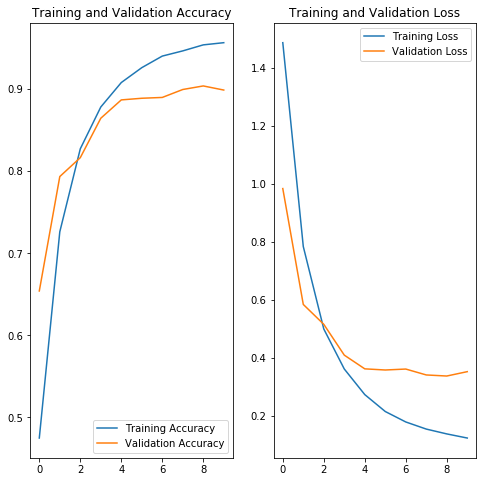

✅


In [16]:
import matplotlib.pyplot as plt

acc = history_wav.history['accuracy']
val_acc = history_wav.history['val_accuracy']

loss=history_wav.history['loss']
val_loss=history_wav.history['val_loss']

epochs_range = range(len(acc))

plt.figure(figsize=(8, 8))
plt.subplot(1, 2, 1)
plt.plot(epochs_range, acc, label='Training Accuracy')
plt.plot(epochs_range, val_acc, label='Validation Accuracy')
plt.legend(loc='lower right')
plt.title('Training and Validation Accuracy')

plt.subplot(1, 2, 2)
plt.plot(epochs_range, loss, label='Training Loss')
plt.plot(epochs_range, val_loss, label='Validation Loss')
plt.legend(loc='upper right')
plt.title('Training and Validation Loss')
plt.show()
print("✅")

Evaluation

In [17]:
model_wav.load_weights(checkpoint_dir)
print("✅")

✅


In [18]:
results = model_wav.evaluate(test_dataset)
print("✅")

112/112 [==============================] - 16s 145ms/step - loss: 0.3386 - accuracy: 0.9037
✅


In [19]:
inv_label_value = {v: k for k, v in label_value.items()}
batch_index = np.random.choice(len(test_wav), size=1, replace=False)

batch_xs = test_wav[batch_index]
batch_ys = test_label[batch_index]
y_pred_ = model_wav(batch_xs, training=False)

print("label : ", str(inv_label_value[batch_ys[0]]))

ipd.Audio(batch_xs.reshape(130,126), rate=130)

label :  up


In [20]:
if np.argmax(y_pred_) == batch_ys[0]:
    print("y_pred: " + str(inv_label_value[np.argmax(y_pred_)]) + '(Correct!)')
else:
    print("y_pred: " + str(inv_label_value[np.argmax(y_pred_)]) + '(Incorrect!)')
print("✅")

y_pred: up(Correct!)
✅
